
# Non-linear feature engineering for Logistic Regression

In the slides at the beginning of the module we mentioned that linear
classification models are not suited to non-linearly separable data.
Nevertheless, one can still use feature engineering as previously done for
regression models to overcome this issue. To do so, we use non-linear
transformations that typically map the original feature space into a higher
dimension space, where the linear model can separate the data more easily.

Let us illustrate this on three synthetic datasets. Each dataset has two
original features and two classes to make it easy to visualize. The first
dataset is called the "moons" dataset as the data points from each class are
shaped as a crescent moon:

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons

feature_names = ["Feature #0", "Feature #1"]
target_name = "class"

X, y = make_moons(n_samples=100, noise=0.13, random_state=42)

# We store both the data and target in a dataframe to ease plotting
moons = pd.DataFrame(
    np.concatenate([X, y[:, np.newaxis]], axis=1),
    columns=feature_names + [target_name],
)
data_moons, target_moons = moons[feature_names], moons[target_name]


The second dataset is called the "Gaussian quantiles" dataset as all data
points are sampled from a 2D Gaussian distribution regardless of the class.
The points closest to the center are assigned to the class 1 while the points
in the outer edges are assigned to the class 0, resulting in concentric
circles.

In [2]:
from sklearn.datasets import make_gaussian_quantiles

X, y = make_gaussian_quantiles(
    n_samples=100, n_features=2, n_classes=2, random_state=42
)
gauss = pd.DataFrame(
    np.concatenate([X, y[:, np.newaxis]], axis=1),
    columns=feature_names + [target_name],
)
data_gauss, target_gauss = gauss[feature_names], gauss[target_name]


The third dataset is called the "XOR" dataset as the data points are sampled
from a uniform distribution in a 2D space and the class is defined by the
Exclusive OR (XOR) operation on the two features: the target class is 1 if
only one of the two features is greater than 0. The target class is 0
otherwise.

In [3]:
xor = pd.DataFrame(
    np.random.RandomState(0).uniform(low=-1, high=1, size=(200, 2)),
    columns=feature_names,
)
target_xor = np.logical_xor(xor["Feature #0"] > 0, xor["Feature #1"] > 0)
target_xor = target_xor.astype(np.int32)
xor["class"] = target_xor
data_xor = xor[feature_names]


We use matplotlib to visualize all the datasets at a glance:

[Text(0.5, 1.0, 'The XOR dataset'), Text(0.5, 0, 'Feature #0')]

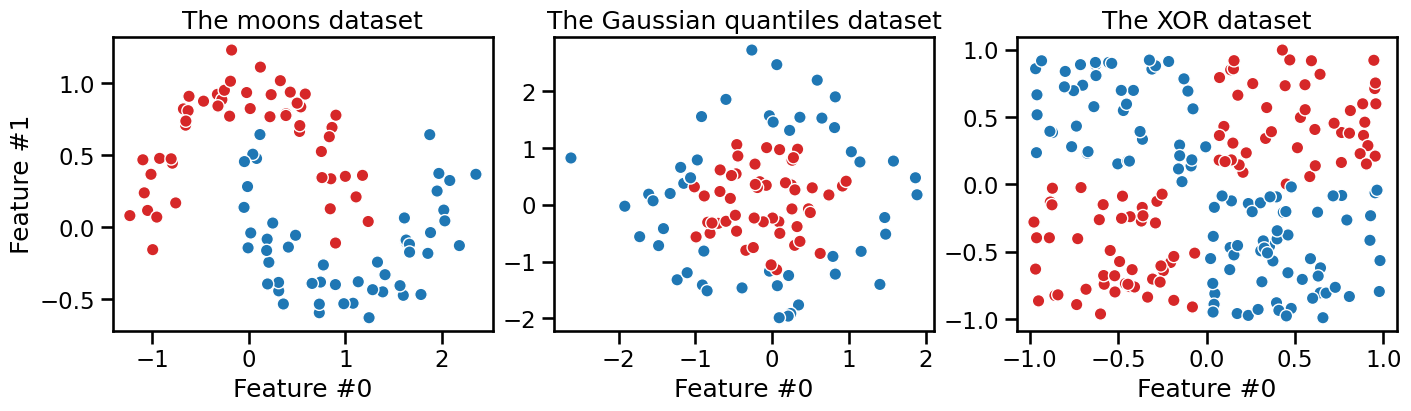

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


_, axs = plt.subplots(ncols=3, figsize=(14, 4), constrained_layout=True)

common_scatter_plot_params = dict(
    cmap=ListedColormap(["tab:red", "tab:blue"]),
    edgecolor="white",
    linewidth=1,
)

axs[0].scatter(
    data_moons[feature_names[0]],
    data_moons[feature_names[1]],
    c=target_moons,
    **common_scatter_plot_params,
)
axs[1].scatter(
    data_gauss[feature_names[0]],
    data_gauss[feature_names[1]],
    c=target_gauss,
    **common_scatter_plot_params,
)
axs[2].scatter(
    data_xor[feature_names[0]],
    data_xor[feature_names[1]],
    c=target_xor,
    **common_scatter_plot_params,
)
axs[0].set(
    title="The moons dataset",
    xlabel=feature_names[0],
    ylabel=feature_names[1],
)
axs[1].set(
    title="The Gaussian quantiles dataset",
    xlabel=feature_names[0],
)
axs[2].set(
    title="The XOR dataset",
    xlabel=feature_names[0],
)


We intuitively observe that there is no (single) straight line that can
separate the two classes in any of the datasets. We can confirm this by
fitting a linear model, such as a logistic regression, to each dataset and
plot the decision boundary of the model.

Let's first define a function to help us fit a given model and plot its
decision boundary on the previous datasets at a glance:

In [5]:
from sklearn.inspection import DecisionBoundaryDisplay


def plot_decision_boundary(model, title=None):
    datasets = [
        (data_moons, target_moons),
        (data_gauss, target_gauss),
        (data_xor, target_xor),
    ]
    fig, axs = plt.subplots(
        ncols=3,
        figsize=(14, 4),
        constrained_layout=True,
    )

    for i, ax, (data, target) in zip(
        range(len(datasets)),
        axs,
        datasets,
    ):
        model.fit(data, target)
        DecisionBoundaryDisplay.from_estimator(
            model,
            data,
            response_method="predict_proba",
            plot_method="pcolormesh",
            cmap="RdBu",
            alpha=0.8,
            # Setting vmin and vmax to the extreme values of the probability to
            # ensure that 0.5 is mapped to white (the middle) of the blue-red
            # colormap.
            vmin=0,
            vmax=1,
            ax=ax,
        )
        DecisionBoundaryDisplay.from_estimator(
            model,
            data,
            response_method="predict_proba",
            plot_method="contour",
            alpha=0.8,
            levels=[0.5],  # 0.5 probability contour line
            linestyles="--",
            linewidths=2,
            ax=ax,
        )
        ax.scatter(
            data[feature_names[0]],
            data[feature_names[1]],
            c=target,
            **common_scatter_plot_params,
        )
        if i > 0:
            ax.set_ylabel(None)
    if title is not None:
        fig.suptitle(title)


Now let's define our logistic regression model and plot its decision boundary
on the three datasets:

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logistic_regression = make_pipeline(StandardScaler(), LogisticRegression())
logistic_regression

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

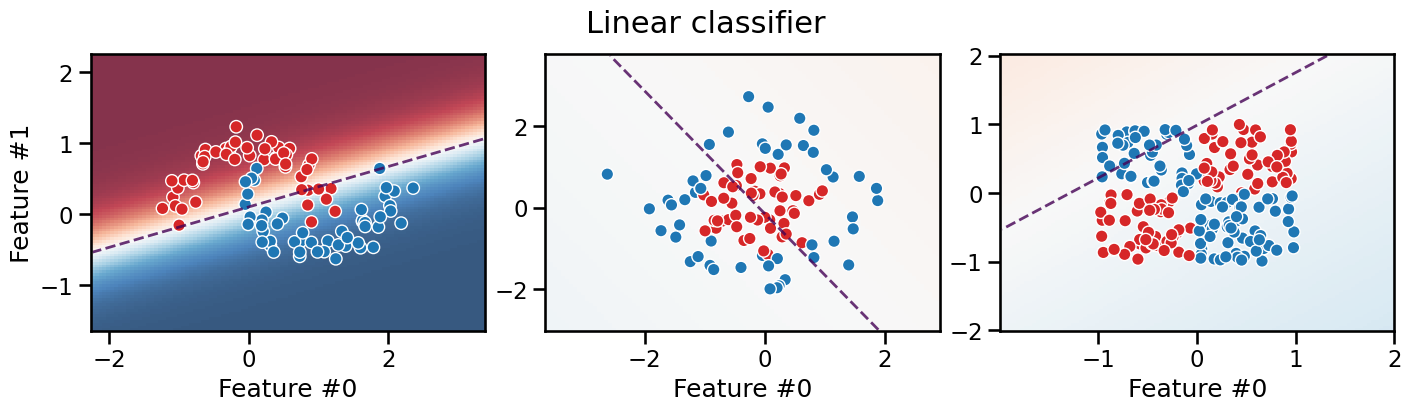

In [7]:
plot_decision_boundary(logistic_regression, title="Linear classifier")


This confirms that it is not possible to separate the two classes with a
linear model. On each plot we see a **significant number of misclassified
samples on the training set**! The three plots show typical cases of
**underfitting** for linear models.

Also, the last two plots show soft colors, meaning that the model is highly
unsure about which class to choose.


## Engineering non-linear features

As we did for the linear regression models, we now attempt to build a more
expressive machine learning pipeline by leveraging non-linear feature
engineering, with techniques such as binning, splines, polynomial features,
and kernel approximation.

Let's start with the binning transformation of the features:

In [8]:
from sklearn.preprocessing import KBinsDiscretizer

classifier = make_pipeline(
    KBinsDiscretizer(n_bins=5, encode="onehot"),  # already the default params
    LogisticRegression(),
)
classifier

Pipeline(steps=[('kbinsdiscretizer', KBinsDiscretizer()),
                ('logisticregression', LogisticRegression())])

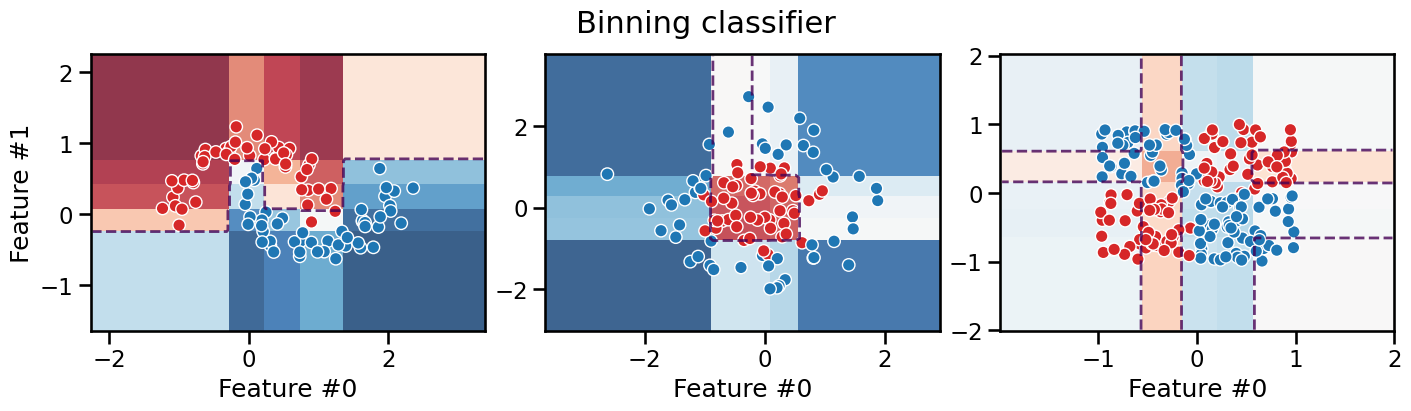

In [9]:
plot_decision_boundary(classifier, title="Binning classifier")


We can see that the resulting decision boundary is constrained to follow
**axis-aligned segments**, which is very similar to what a decision tree would
do as we will see in the next Module. Furthermore, as for decision trees, the
model makes piecewise constant predictions within each rectangular region.

This axis-aligned decision boundary is not necessarily the natural decision
boundary a human would have intuitively drawn for the moons dataset and the
Gaussian quantiles datasets. It still makes it possible for the model to
successfully separate the data. However, binning alone does not help the
classifier separate the data for the XOR dataset. This is because **the
binning transformation is a feature-wise transformation** and thus **cannot
capture interactions** between features that are necessary to separate the
XOR dataset.

Let's now consider a **spline** transformation of the original features. This
transformation can be considered a **smooth version of the binning
transformation**. You can find more details in the [scikit-learn user guide](
https://scikit-learn.org/stable/modules/preprocessing.html#spline-transformer).

In [10]:
from sklearn.preprocessing import SplineTransformer

classifier = make_pipeline(
    SplineTransformer(degree=3, n_knots=5),
    LogisticRegression(),
)
classifier

Pipeline(steps=[('splinetransformer', SplineTransformer()),
                ('logisticregression', LogisticRegression())])

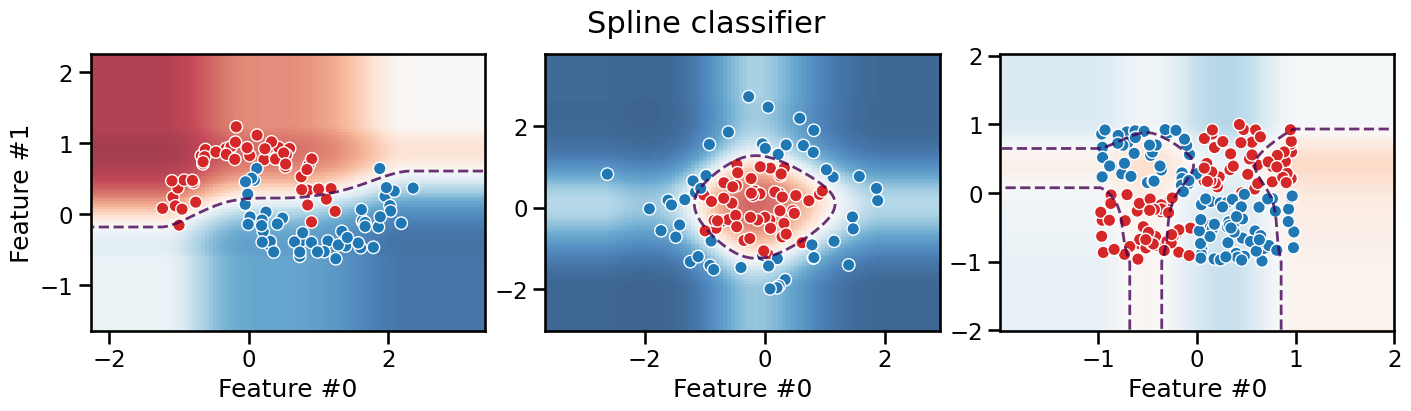

In [11]:
plot_decision_boundary(classifier, title="Spline classifier")


We can see that the decision boundary is now smooth, and while it favors
axis-aligned decision rules when extrapolating in low density regions, it can
adopt a more curvy decision boundary in the high density regions.
However, as for the binning transformation, the model still fails to separate
the data for the XOR dataset, irrespective of the number of knots, for the
same reasons: **the spline transformation is a feature-wise transformation**
and thus **cannot capture interactions** between features.

Take into account that the number of knots is a hyperparameter that needs to be
tuned. If we use too few knots, the model would underfit the data, as shown on
the moons dataset. If we use too many knots, the model would overfit the data.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Notice that <tt class="docutils literal"><span class="pre">KBinsDiscretizer(encode="onehot")</span></tt> and <tt class="docutils literal">SplineTransformer</tt> do not
require additional scaling. Indeed, they can replace the scaling step for
numerical features: they both create features with values in the [0, 1] range.</p>
</div>


## Modeling non-additive feature interactions

We now consider feature engineering techniques that non-linearly combine the
original features in the hope of capturing interactions between them. We will
consider polynomial features and kernel approximation.

Let's start with the polynomial features:

In [12]:
from sklearn.preprocessing import PolynomialFeatures

classifier = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=3, include_bias=False),
    LogisticRegression(C=10),
)
classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('logisticregression', LogisticRegression(C=10))])

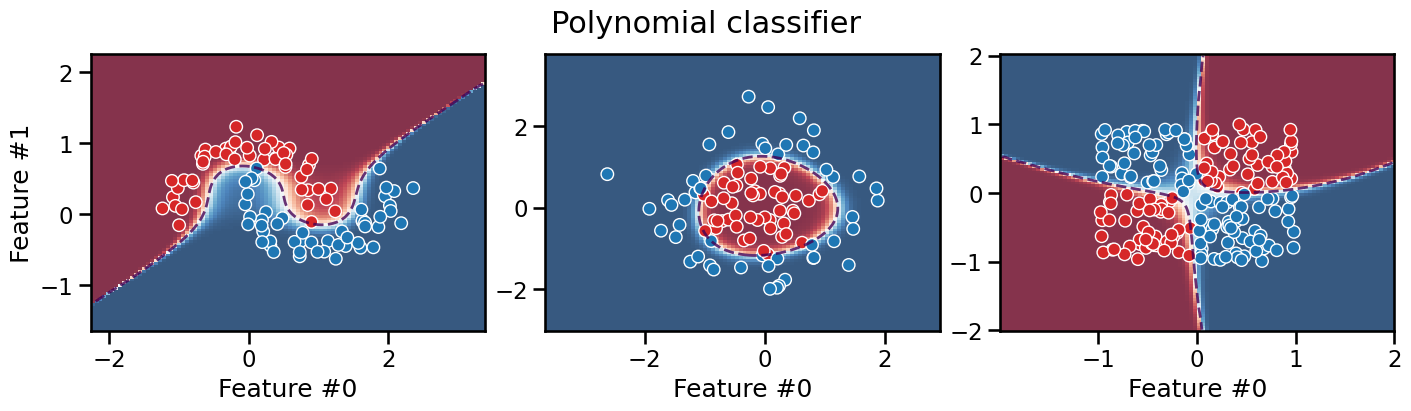

In [13]:
plot_decision_boundary(classifier, title="Polynomial classifier")


We can see that the decision boundary of this polynomial classifier is
**smooth** and can successfully separate the data on all three datasets
(depending on how we set the values of the `degree` and `C`
hyperparameters).

It is interesting to observe that this models extrapolates very differently
from the previous models: its decision boundary can take a diagonal
direction. Furthermore, we can observe that predictions are very confident in
the low density regions of the feature space, even very close to the decision
boundary

We can obtain very similar results by using a kernel approximation technique
such as the Nyström method with a polynomial kernel:

In [14]:
from sklearn.kernel_approximation import Nystroem

classifier = make_pipeline(
    StandardScaler(),
    Nystroem(kernel="poly", degree=3, coef0=1, n_components=100),
    LogisticRegression(C=10),
)
classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nystroem', Nystroem(coef0=1, degree=3, kernel='poly')),
                ('logisticregression', LogisticRegression(C=10))])

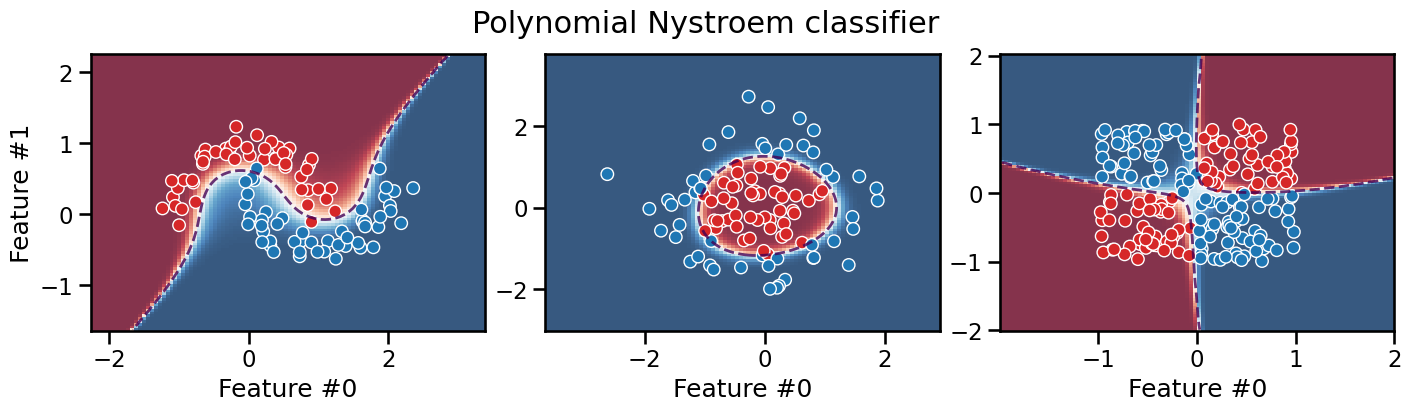

In [15]:
plot_decision_boundary(classifier, title="Polynomial Nystroem classifier")


The polynomial kernel approach would be interesting in cases were the
original feature space is already of high dimension: in these cases,
**computing the complete polynomial expansion** with `PolynomialFeatures`
could be **intractable**, while Nyström method can control the output
dimensionality with the `n_components` parameter.

Let's now explore the use of a radial basis function (RBF) kernel:

In [16]:
from sklearn.kernel_approximation import Nystroem

classifier = make_pipeline(
    StandardScaler(),
    Nystroem(kernel="rbf", gamma=1, n_components=100),
    LogisticRegression(C=5),
)
classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nystroem', Nystroem(gamma=1)),
                ('logisticregression', LogisticRegression(C=5))])

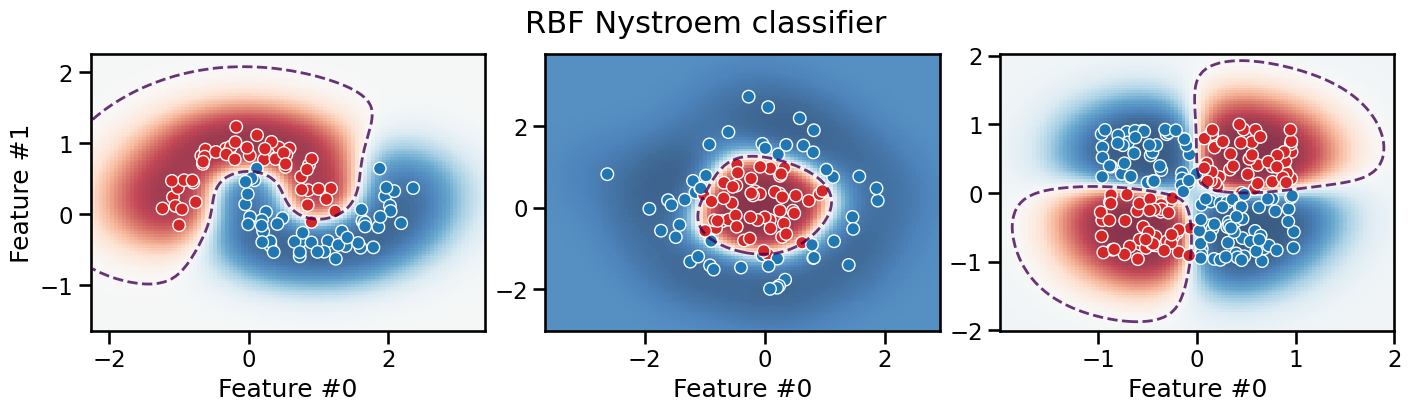

In [17]:
plot_decision_boundary(classifier, title="RBF Nystroem classifier")


The resulting decision boundary is **smooth** and can successfully separate
the classes for all three datasets. Furthemore, the model extrapolates very
differently: in particular, it tends to be **much less confident in its
predictions in the low density regions** of the feature space.

As for the previous polynomial pipelines, this pipeline **does not favor
axis-aligned decision rules**. It can be shown mathematically that the
[inductive bias](https://en.wikipedia.org/wiki/Inductive_bias) of our RBF
pipeline is actually rotationally invariant.


## Multi-step feature engineering

It is possible to combine several feature engineering transformers in a
single pipeline to blend their respective inductive biases. For instance, we
can combine the binning transformation with a kernel approximation:

In [18]:
classifier = make_pipeline(
    KBinsDiscretizer(n_bins=5),
    Nystroem(kernel="rbf", gamma=1.0, n_components=100),
    LogisticRegression(),
)
classifier

Pipeline(steps=[('kbinsdiscretizer', KBinsDiscretizer()),
                ('nystroem', Nystroem(gamma=1.0)),
                ('logisticregression', LogisticRegression())])

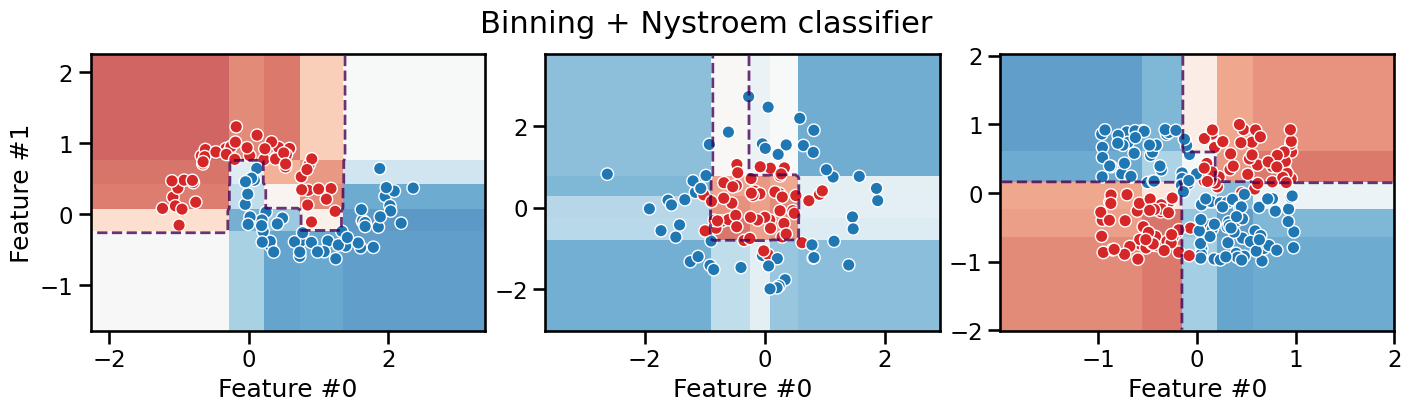

In [19]:
plot_decision_boundary(classifier, title="Binning + Nystroem classifier")


It is interesting to observe that this model is still piecewise constant with
axis-aligned decision boundaries everywhere, but it can now successfully deal
with the XOR problem thanks to the second step of the pipeline that can
model the interactions between the features transformed by the first step.

We can also combine the spline transformation with a kernel approximation:

In [20]:
from sklearn.kernel_approximation import Nystroem

classifier = make_pipeline(
    SplineTransformer(n_knots=5),
    Nystroem(kernel="rbf", gamma=1.0, n_components=100),
    LogisticRegression(),
)
classifier

Pipeline(steps=[('splinetransformer', SplineTransformer()),
                ('nystroem', Nystroem(gamma=1.0)),
                ('logisticregression', LogisticRegression())])

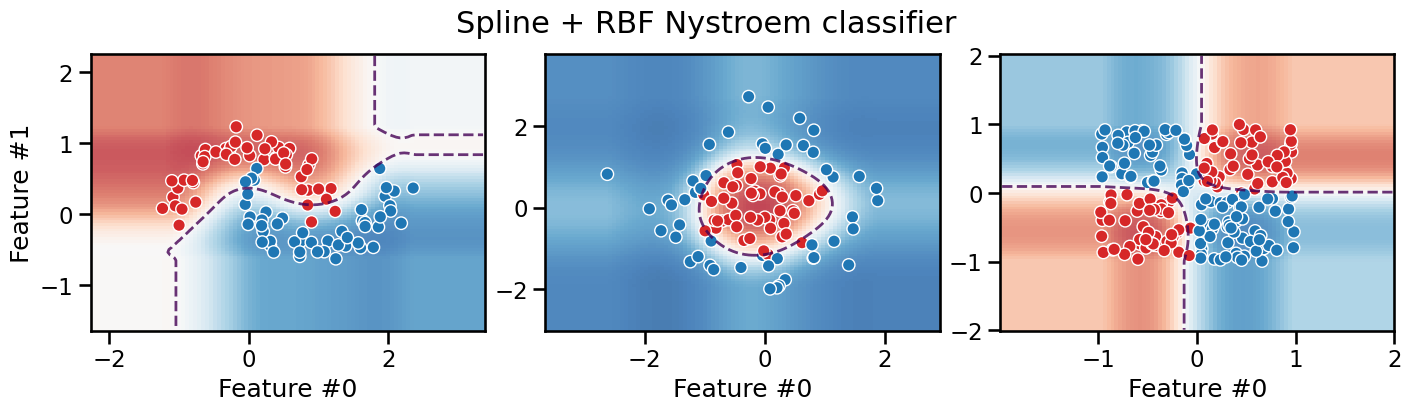

In [21]:
plot_decision_boundary(classifier, title="Spline + RBF Nystroem classifier")


The decision boundary of this pipeline is smooth, but with axis-aligned
extrapolation.

Depending on the task, this can be considered an advantage or a drawback.


## Summary and take-away messages

- Linear models such as logistic regression can be used for classification on
  non-linearly separable datasets by leveraging non-linear feature
  engineering.
- Transformers such as `KBinsDiscretizer` and `SplineTransformer` can be used
  to engineer non-linear features independently for each original feature.
- As a result, these transformers cannot capture interactions between the
  orignal features (and then would fail on the XOR classification task).
- Despite this limitation they already augment the expressivity of the
  pipeline, which can be sufficient for some datasets.
- They also favor axis-aligned decision boundaries, in particular in the low
  density regions of the feature space (axis-aligned extrapolation).
- Transformers such as `PolynomialFeatures` and `Nystroem` can be used to
  engineer non-linear features that capture interactions between the original
  features.
- It can be useful to combine several feature engineering transformers in a
  single pipeline to build a more expressive model, for instance to favor
  axis-aligned extrapolation while also capturing interactions.
- In particular, if the original dataset has both numerical and categorical
  features, it can be useful to apply binning or a spline transformation to the
  numerical features and one-hot encoding to the categorical features. Then,
  the resulting features can be combined with a kernel approximation to model
  interactions between numerical and categorical features. This can be
  achieved with the help of `ColumnTransformer`.

In subsequent notebooks and exercises, we will further explore the interplay
between regularization, feature engineering, and the under-fitting /
overfitting trade-off.

But first we will do an exercise to illustrate the relationship between the
Nyström kernel approximation and support vector machines.